In [274]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

In [ ]:
#pip install albumentations

In [ ]:
# image_id = os.listdir( './data/train')
# image_id_set = []
# for i in image_id:
#     i = i.split('.')[0]
#     image_id_set.append(i)
# image_id_set = set(image_id_set)
#image_id = set(image_id)

### Load Dataset

In [275]:
train_df = pd.read_csv('./data/train.csv')
train_df.shape

(147793, 5)

In [276]:
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [277]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)

In [278]:
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [279]:
#resize bbox 512/1024
train_df['x'] = train_df['x']*(250/1024)
train_df['y'] = train_df['y']*(250/1024)
train_df['w'] = train_df['w']*(250/1024)
train_df['h'] = train_df['h']*(250/1024)

In [280]:
train_df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,203.613281,54.199219,13.671875,8.789062
1,b6ab77fd7,1024,1024,usask_1,55.175781,133.789062,31.738281,14.160156
2,b6ab77fd7,1024,1024,usask_1,92.041016,123.046875,18.066406,39.062500
3,b6ab77fd7,1024,1024,usask_1,203.613281,23.193359,26.611328,26.123047
4,b6ab77fd7,1024,1024,usask_1,6.347656,35.156250,30.273438,28.564453


In [281]:
# train test split 0.8/0.2
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

In [282]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [283]:
valid_df.shape, train_df.shape

((25006, 8), (122787, 8))

### Dataset

In [284]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        #print(image_id)
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        #reszie image to 512*512
        dim = (250, 250)
        resized_img = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
        resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB).astype(np.float32)
        #resized_img /= 512.0 #normalization

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = torch.tensor(boxes)
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': resized_img,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)


        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

### Data Augmentation

In [285]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(p=0.5),
        A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2,
                                      sat_shift_limit=0.2,
                                      val_shift_limit=0.2,
                                      p=0.5),
                 A.RandomBrightnessContrast(brightness_limit=0.2,
                                            contrast_limit=0.2,
                                            p=0.5)],
                p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [286]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [287]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [288]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [289]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, './data/train', get_train_transform())
valid_dataset = WheatDataset(valid_df, './data/train', get_valid_transform())
# train_dataset = WheatDataset(train_df, './data/train')
# valid_dataset = WheatDataset(valid_df, './data/train')

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [290]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [291]:
images, targets, image_ids = next(iter(train_data_loader))
images =[torch.as_tensor(image, dtype = torch.float32).permute(1,2,0).cuda() for image in images]
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [292]:
images[0].shape

torch.Size([250, 250, 3])

### Sample

In [293]:
boxes = targets[5]['boxes'].cpu().numpy().astype(np.int32)
sample = images[5].permute(0,1,2).cpu().numpy()

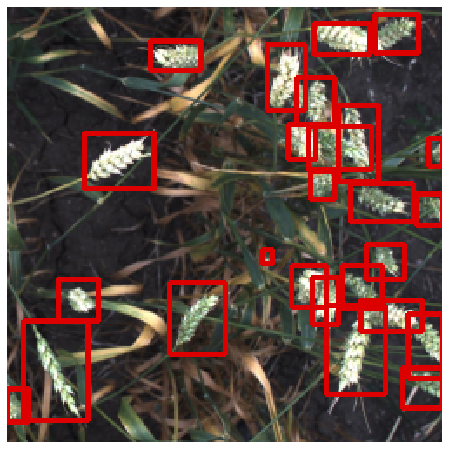

In [296]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,(box[0], box[1]),(box[2], box[3]),(220,0,0),2)
    
ax.set_axis_off()
ax.imshow(sample.astype('uint8'))

In [297]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 2

In [298]:
images, targets, image_ids = next(iter(train_data_loader))

In [299]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
#             for im, targ in zip(images, targets):
#                 if torch.isnan(im).any():
#                     info = f'ERROR: NaN in input image. Epoch {epoch}, iteration {itr}.'
#                     print(info)
#                     continue  
#             for k, v in targ.items():
#                 if torch.isnan(v).any():
#                     info = f'ERROR: NaN in target {k}. Epoch {epoch}, iteration {itr}.'
#                     print(info)
#                     continue
        
            images =[torch.as_tensor(image, dtype = torch.float32).cuda() for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            
#             if not math.isfinite(loss_value):
#                 info = f'Loss {loss_value} is not finite. Epoch {epoch}, iteration {itr}.'
#                 print(info)
#                 optimizer.zero_grad()
#                 continue            

            loss_hist.send(loss_value)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if itr % 50 == 0:
                print(f"Iteration #{itr} loss: {loss_value}")

            itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

RuntimeError: CUDA out of memory. Tried to allocate 80.00 MiB (GPU 0; 11.17 GiB total capacity; 10.70 GiB already allocated; 48.31 MiB free; 10.78 GiB reserved in total by PyTorch)

In [273]:
torch.cuda.empty_cache()

In [ ]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()